<a href="https://colab.research.google.com/github/Douglasbpinheiro/LGD_ML/blob/main/Modelo_LGD_ML_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 0) Modelo de LGD - ML

Nesse primeiro modelo utilizamos a biblioteca AutoSklearn.



# 1) Importando e tratando os dados

### Dicas de analise inicial e dados importados do link [Kaggle](https://www.kaggle.com/ztrimus/loan-repayment-prediction) inclusive com ML e avaliação. 





1. Nessa etapa foram mantidos apenas os registros elegíveis à apuração do LGD, pelo critéio `loan_status`.
```
df0 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, nrows = 1500000)
df0 = df0[df0['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] 
df1 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, skiprows=[i for i in range(1,1500000)])
df1 = df1[df1['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] 
df = df0.append(df1, ignore_index=True)
df.to_csv('df.csv.zip', index=True, compression='zip')
```


2. Foram excluídas 31 observações devido ao principal ter sido 100% recuperado.Nessa situação o denominador do LGD=0.
```
df = df[(df['loan_amnt']-df['total_rec_prncp'])>0] 
```

3. Foram gerados os dados para estudo do período e work-out. Com base nos dados abaixo foram selecionados os anos de `2014 a 2017` para o estudo. O que nos deixou com 266.515 observações.
```
lgd = df.groupby(['year'], as_index=False).agg({'id':'count', 'lgd_c': np.mean, 'lgd_c_d': np.mean})
lgd.to_excel('lgd.xlsx', index = False, header=True)
df = df[df.year.isin([2014, 2015, 2016, 2017])]
```

4. Por fim, foi analisada a distribuição do LGD por ano e ela se manteve estável, depois foi avaliada se a renda não verificada deveria ser excluída, conforme artigo `P2P`, e notamos que não há diferença no nível de LGD entre os tipos de verificação. Finalmente incluímos os custos de recuperação referente ao comissionamento e vimos que, em média, representam 17,5% da recuperação observada.
```
fig = plt.figure(); 
df.hist(column='lgd', by='year', grid=False, histtype='barstacked', bins=25, sharey=False, legend=False, color='black', range=[0,1], figsize = (10, 7))
plt.show()
df.groupby(['verification_status'], as_index=False).agg({'id':'count', 'lgd': np.mean, 'lgd_d': np.mean})
df.groupby(['year'], as_index=False).agg({'id':'count', 'collection_recovery_fee': np.sum, 'recoveries': np.sum})
```


In [1]:
#Conecta o google drive ao ambiente de trabalho
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# 2) Desenvolvimento com Auto Sklearn

> Sempre instalar as bibliotecas e reiniciar o ambiente depois


In [ ]:
!pip install scikit-learn

In [ ]:
!pip install auto-sklearn

In [2]:
# Importa os dados a partir do google drive e faz os tratamentos da variável resposta, gerando a base LGD
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)     # ajuste da visualização de tabela para todas as colunas
pd.set_option('display.max_rows', None)        # ajuste da visualização de tabela para todas as linhas
pd.set_option('mode.chained_assignment', None) # evita o aviso de processamento do Pandas

os.chdir('/content/drive/My Drive/Colab Notebooks/')
#os.chdir('/content/drive/My Drive/Colab Notebooks/2_Dados/')
df = pd.read_csv('lgd.csv.zip', compression='zip', low_memory=False, index_col=0)

# Transforma a informação de data de concessão do crédito e deleta a variável original, bem como o status do empréstimo
#df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%Y')
df['year'] = pd.DatetimeIndex(df['issue_d']).year

# Exclui os casos com principal totalmente pago, para evitar problema no calculo da resposta
df = df[(df['loan_amnt']-df['total_rec_prncp'])>0] # Exclusão 31 observações

# Construindo a variável resposta LDG_c_custo
df['lgd'] = 1-((df['recoveries']-df['collection_recovery_fee'])/(df['loan_amnt']-df['total_rec_prncp']))
df['lgd'] = np.where(df['lgd'] < -0.3, -0.3, df['lgd']) # 17 censurados
df = df[df.year.isin([2014, 2015, 2016, 2017])]

# transformando o plano de pagamento em numérico e depois em dummy = 1 (60 meses)
df['term_c'] = np.where(pd.to_numeric(df['term'].str.replace(' months', ''))==60, 1, 0)

# transformando a taxa de juros em numérico
df['int_rate_n'] = pd.to_numeric(df['int_rate'].str.replace('%', ''))

# Tratando a variável subgrade, de categorias para contínua
a = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,\
     'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,\
     'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,'G1':31,'G2':32,'G3':33,'G4':34,'G5':35}
df['sub_grade_n'] = df['sub_grade'].map(a)

# Tratando o texto da variável tempo de emprego
df['emp_length_n'] = df['emp_length'].str.replace('\+ years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace('< 1 year', str(0)) #subst <1 ano por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace('n/a',  str(0)) #subst S/I por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace(' years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace(' year', '') #subst palavra por vazio
df['emp_length_n'] = pd.to_numeric(df['emp_length_n']) #Transforma em numérico
df['emp_length_n'] = np.where(df['emp_length_n']==0, 0.5, df['emp_length_n']) # Transforma 0 anos em 0.5 
df['emp_length_n'].fillna(0, inplace=True) # nos casos sem informação assume-se 0 (pior condição)

# Categorizada em verificada e não verificada
b = {'Not Verified':0,'Source Verified':1,'Verified':1}
df['verification_c'] = df['verification_status'].map(b)

# Tratando o dti - endividamento
df['dti'].fillna(0, inplace=True) #85 nulas

# Data da primeira linha de crédito, transformado em tempo de relacionamento no mercado em anos base 2017
df['earliest_cr_line_n'] = 2017 - pd.DatetimeIndex(df['earliest_cr_line']).year

# Preenchendo com 0 os valores nulos e criando indicador de não ocorrencia
df['mths_since_last_delinq_null'] = np.where(df['mths_since_last_delinq'].isnull(),1,0) 
df['mths_since_last_delinq'].fillna(0, inplace=True) #125323 nulas
df['mths_since_last_record_null'] = np.where(df['mths_since_last_record'].isnull(),1,0) 
df['mths_since_last_record'].fillna(0, inplace=True) #210424 nulas
df['mths_since_last_major_derog_null'] = np.where(df['mths_since_last_major_derog'].isnull(),1,0) 
df['mths_since_last_major_derog'].fillna(0, inplace=True) #183776 nulas

# Preenchendo com 0 os valores nulos e transforma a info em número ao invés de texto
df['revol_util_n'] = pd.to_numeric(np.where(df['revol_util'].isnull(),0,df['revol_util'].str.replace('%', '')))

# Categorizando variáveis para empréstimos conjuntos e preenchendo com 0 os valores nulos
c = {'Joint App':0,'Individual':1}
df['application_type_c'] = df['application_type'].map(c)

# Preenchendo nulos com zeros
df['open_acc_6m'].fillna(0, inplace=True) #117319 nulas
df['open_act_il'].fillna(0, inplace=True) #117319 nulas
df['open_il_12m'].fillna(0, inplace=True) #117319 nulas
df['open_il_24m'].fillna(0, inplace=True) #117319 nulas
df['mths_since_rcnt_il'].fillna(0, inplace=True) #121784 nulas
df['total_bal_il'].fillna(0, inplace=True) #117319 nulas
df['il_util'].fillna(0, inplace=True) #136010 nulas
df['open_rv_12m'].fillna(0, inplace=True) #117319 nulas
df['open_rv_24m'].fillna(0, inplace=True) #117319 nulas
df['max_bal_bc'].fillna(0, inplace=True) #117319 nulas
df['all_util'].fillna(0, inplace=True) #117319 nulas
df['inq_fi'].fillna(0, inplace=True) #117319 nulas
df['total_cu_tl'].fillna(0, inplace=True) #117319 nulas
df['inq_last_12m'].fillna(0, inplace=True) #117319 nulas
df['avg_cur_bal'].fillna(0, inplace=True) #5 nulas
df['bc_open_to_buy'].fillna(0, inplace=True) #2929 nulas
df['bc_util'].fillna(0, inplace=True) #3090 nulas
df['mo_sin_old_il_acct'].fillna(0, inplace=True) #7939 nulas
df['num_tl_120dpd_2m'].fillna(0, inplace=True) #16062 nulas
df['percent_bc_gt_75'].fillna(0, inplace=True) #3009 nulas

# Categorizando variáveis atrasos em contas internas e preenchendo com 0 os valores nulos
df['mths_since_recent_bc'].fillna(0, inplace=True) #2764 nulas
df['mths_since_recent_bc_dlq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_bc_dlq_null'] = np.where(df['mths_since_recent_bc_dlq'].isnull(),1,0) 
df['mths_since_recent_inq'].fillna(0, inplace=True) #19513 nulas
df['mths_since_recent_revol_delinq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_revol_delinq_null'] = np.where(df['mths_since_recent_revol_delinq'].isnull(),1,0) 

df = df[['lgd','year','loan_amnt','funded_amnt_inv','term_c','int_rate_n','installment','grade','sub_grade_n',\
         'emp_length_n','home_ownership','annual_inc','verification_c','purpose','dti','delinq_2yrs',\
         'earliest_cr_line_n','fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_delinq',\
         'mths_since_last_delinq_null','mths_since_last_record','mths_since_last_record_null','open_acc','pub_rec','revol_bal',\
         'revol_util_n','total_acc','total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee',\
         'last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','mths_since_last_major_derog',\
         'mths_since_last_major_derog_null','application_type_c','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m',\
         'open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',\
         'open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m',\
         'acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths','delinq_amnt',\
         'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',\
         'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_bc_dlq_null',\
         'mths_since_recent_inq','mths_since_recent_revol_delinq','mths_since_recent_revol_delinq_null',\
         'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',\
         'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',\
         'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',\
         'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit']]

# Cria as dummies e concatena na tabela final 
dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ':'),
           pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
           pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = ':')]

dummies = pd.concat(dummies, axis = 1)
df1 = pd.concat([df, dummies], axis = 1)
df1 = df1.drop(['grade','grade:G','home_ownership','home_ownership:RENT','purpose','purpose:small_business'], axis = 1)
df1.shape #(266515, 112)
del df, dummies

df1.shape #(266515, 112)
#df1.tail(5)
#Exportando para o excel - lembrar de sincronizar o drive
#df1.to_excel(r'teste.xlsx', index = True, header=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.


(266515, 112)

In [3]:
from sklearn.model_selection import train_test_split # Import train_test_split function

# seleciona a base de deselvolvimento
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
#df_des = df_des.sample(frac =.25, replace = False, random_state = 2) #25%
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
#df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%

y = df_des.pop('lgd').to_numpy() 
X = df_des.to_numpy()

# Determinação da amostra de treinamento e  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test

# Separa as amostras de validação out-of-time
X_2016 = df1[df1['year']==2016].drop(columns=['year']) #(78998, 111)
X_2017 = df1[df1['year']==2017].drop(columns=['year']) #(66083, 111)
y_2016 = X_2016.pop('lgd').to_numpy() 
X_2016 = X_2016.to_numpy()
y_2017 = X_2017.pop('lgd').to_numpy() 
X_2017 = X_2017.to_numpy()

(X_train.shape, y_train.shape, X_test.shape, y_test.shape,)

((97147, 110), (97147,), (24287, 110), (24287,))

In [4]:
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=3600, #1 hora total
    per_run_time_limit = 500,
)
automl.fit(X_train, y_train, feat_type=['Numerical']*110)

# Retorna o valor previsto nas diferentes amostras
y_pred_train = automl.predict(X_train)
y_pred_test = automl.predict(X_test)
y_pred_2016 = automl.predict(X_2016)
y_pred_2017 = automl.predict(X_2017)

#View the models found by auto-sklearn
print(automl.leaderboard())

          rank  ensemble_weight            type      cost    duration
model_id                                                             
7            1             0.48  ard_regression  0.338614   86.203750
11           2             0.30     extra_trees  0.347849  481.899544
30           3             0.22   decision_tree  0.473072    8.197577


In [8]:
# Print the final ensemble constructed by auto-sklearn
from pprint import pprint
pprint(automl.show_models(), indent=4)

{   7: {   'cost': 0.33861433257560125,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f57a5b4a310>,
           'ensemble_weight': 0.48,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f57a5975410>,
           'model_id': 7,
           'rank': 1,
           'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f57a5dbbe10>,
           'sklearn_regressor': ARDRegression(alpha_1=2.7664515192592053e-05, alpha_2=9.504988116581138e-07,
              copy_X=False, lambda_1=4.184987756432487e-09,
              lambda_2=4.238533890074848e-07,
              threshold_lambda=78251.58542976103, tol=0.0006951835906397672)},
    11: {   'cost': 0.34784855076122434,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f57a5b4aa10>,
            'ensem

In [5]:
#https://scikit-learn.org/stable/modules/model_evaluation.html 
#https://www.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende/?originalSubdomain=pt
#https://realpython.com/numpy-scipy-pandas-correlation-python/
def reg_metrics(y, y_pred, X):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import scipy.stats

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred)) #penaliza mais a existência de outliers, ver o artigo acima
    r2 = r2_score(y,y_pred)
    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    df_y = pd.DataFrame(y, columns = ['y'])
    r = scipy.stats.pearsonr(df_y['y'].tolist(),y_pred.tolist())[0] # Pearson's r
    rho = scipy.stats.spearmanr(df_y['y'].tolist(),y_pred.tolist()).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(df_y['y'].tolist(),y_pred.tolist()).correlation  # Kendall's tau

    print('mae:',round(mae,7),'rmse:',round(rmse,7),'R2:',round(r2,7),'R2_Ajustado:', round(adj_r_sq,7),\
          'Qtd:',n, 'r:', round(r,7), 'rho:', round(rho,7), 'tau:', round(tau,7))

reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

mae: 0.036826 rmse: 0.0644649 R2: 0.7574214 R2_Ajustado: 0.7571464 Qtd: 97147 r: 0.8878603 rho: 0.8974145 tau: 0.7540538
mae: 0.0400575 rmse: 0.0695886 R2: 0.7221953 R2_Ajustado: 0.7209313 Qtd: 24287 r: 0.8661869 rho: 0.8636003 tau: 0.7142966
mae: 0.0402888 rmse: 0.0692625 R2: 0.7148444 R2_Ajustado: 0.7144468 Qtd: 78998 r: 0.8596915 rho: 0.851258 tau: 0.7023607
mae: 0.034007 rmse: 0.0571565 R2: 0.7146899 R2_Ajustado: 0.7142142 Qtd: 66083 r: 0.8592107 rho: 0.8289754 tau: 0.6664224


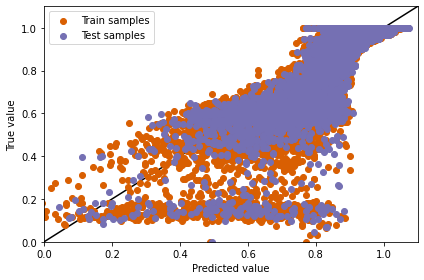

In [6]:
# gráfico do teste vs desenvolvimento -> plotar também no simples

plt.scatter(y_pred_train, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred_test, y_test, label="Test samples", c='#7570b3') 
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([0, 1.1], [0, 1.1], c='k', zorder=0)
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.tight_layout()
plt.show()


# 2) Analise Árvore de Decisão

> A avaliação de possível segmentação das variáveis contínuas ou agrupamento de categóricas em função da resposta `lgd` não se mostrou adequada. Dessa forma será conduzido o desenvolvimento direto do modelo.

> Abaixo o modelo processado para amostras de 2%, 10%, 25% e 100% da base 

In [ ]:
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation 

# Separa as amostras iniciais
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['id','year'])
#df_des = df_des.sample(frac =.25, replace = False, random_state = 2) #25%
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
#df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['id','year'])
df_2017 = df1[df1['year']==2017].drop(columns=['id','year'])

feature_cols = ['loan_amnt','term_c','int_rate_n','ead','ead_inc','ead_loan','emp_length_n',\
                'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','pub_rec','inq_last_12m',\
                'grade:A','grade:B','grade:C','grade:D','grade:E','grade:F',\
                'home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
                'purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:home_improvement',\
                'purpose:house','purpose:major_purchase','purpose:medical','purpose:moving',\
                'purpose:other','purpose:renewable_energy','purpose:vacation']
X = df_des[feature_cols].to_numpy() 
y = df_des[['lgd']].to_numpy() # Target variable
X_2016 = df_2016[feature_cols].to_numpy() 
y_2016 = df_2016[['lgd']].to_numpy() 
X_2017 = df_2017[feature_cols].to_numpy() 
y_2017 = df_2017[['lgd']].to_numpy() 

# Determinação da amostra de treinamento e  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test
# Create Decision Tree Regressor object (resposta contínua)
# clf = DecisionTreeRegressor(max_depth=2,min_samples_leaf=10000)
clf = DecisionTreeRegressor(max_depth=4,min_samples_leaf=0.05, min_impurity_decrease=0.000001)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
# Predict the response for test dataset
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_2016 = clf.predict(X_2016)
y_pred_2017 = clf.predict(X_2017)

# Gera o gráfico da estrutura da árvore
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,leaves_parallel=False,proportion=False,rotate=False, node_ids=True, feature_names = feature_cols),
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('lgd.png')
Image(graph.create_png())


# 3) Regressão Simples

> A avaliação de possível segmentação das variáveis contínuas ou agrupamento de categóricas em função da resposta `lgd` não se mostrou adequada. Dessa forma será conduzido o desenvolvimento direto do modelo.

> Abaixo o modelo processado para amostras de 2%, 10%, 25% e 100% da base 

> Necessário rodar o código abaixo para melhorar a relação das variáveis com a resposta.

In [ ]:
import statsmodels.api as sm

# Separa as amostras iniciais
# ----------------------------------------
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['id','year'])
des_train=df_des.sample(frac=0.8,random_state=2)
des_test=df_des.drop(des_train.index)

#df_des = df_des.sample(frac =.25, replace = False, random_state = 2) #25%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)
#df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['id','year'])
df_2017 = df1[df1['year']==2017].drop(columns=['id','year'])

#feature_cols = ['loan_amnt','term_c','int_rate_n','ead','ead_inc','ead_loan','emp_length_n',\
#                'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','pub_rec','inq_last_12m',\
#                'home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
#                'purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:home_improvement',\
#                'purpose:house','purpose:major_purchase','purpose:medical','purpose:moving',\
#                'purpose:other','purpose:renewable_energy','purpose:vacation']

feature_cols = ['term_c','ead','int_rate_n','ead_loan','emp_length_n',\
                'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','pub_rec',\
                'home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
                'purpose:car','purpose:credit_card','purpose:debt_consolidation',\
                'purpose:other']

X_train = des_train[feature_cols]
y_train = des_train[['lgd']]
y_train.rename(columns = {'lgd':'y'}, inplace = True)
X_test = des_test[feature_cols] 
y_test = des_test[['lgd']]
y_test.rename(columns = {'lgd':'y'}, inplace = True)
X_2016 = df_2016[feature_cols] 
y_2016 = df_2016[['lgd']] 
y_2016.rename(columns = {'lgd':'y'}, inplace = True)
X_2017 = df_2017[feature_cols] 
y_2017 = df_2017[['lgd']] 
y_2017.rename(columns = {'lgd':'y'}, inplace = True)
                     
# Processamento geral para avaliar o primeiro processamento da base.
# Interessante notar que não há a necessidade de converter para estrutura Numpy
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(results.summary())

y_pred_train = results.predict(sm.add_constant(X_train))
y_pred_test = results.predict(sm.add_constant(X_test))
y_pred_2016 = results.predict(sm.add_constant(X_2016))
y_pred_2017 = results.predict(sm.add_constant(X_2017))

In [ ]:
#https://scikit-learn.org/stable/modules/model_evaluation.html 
#https://www.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende/?originalSubdomain=pt
#https://realpython.com/numpy-scipy-pandas-correlation-python/
def reg_metrics(y, y_pred, X):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import scipy.stats

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred)) #penaliza mais a existência de outliers, ver o artigo acima
    r2 = r2_score(y,y_pred)
    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    df_y = pd.DataFrame(y, columns = ['y'])
    r = scipy.stats.pearsonr(df_y['y'].tolist(),y_pred.tolist())[0] # Pearson's r
    rho = scipy.stats.spearmanr(df_y['y'].tolist(),y_pred.tolist()).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(df_y['y'].tolist(),y_pred.tolist()).correlation  # Kendall's tau

    print('mae:',round(mae,7),'rmse:',round(rmse,7),'R2:',round(r2,7),'R2_Ajustado:', round(adj_r_sq,7),\
          'Qtd:',n, 'r:', round(r,7), 'rho:', round(rho,7), 'tau:', round(tau,7))

reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

#4) Validações / Auxiliares

#### 4.1 Abaixo foi gerada uma amostra para validar os indicadores de ajuste do modelo de regressão, e os calculos mostraram-se todos adequados no Python.

#### 4.2 Na sequência há um código para calcular o VIF das variáveis. Teste importante.


In [ ]:
# geração de base para teste dos indicadores -> Todos os indicadores de qualidade validados
# ----------------------------------------------------------------------
df_y_pred_test = pd.DataFrame(y_pred_2016, columns = ['y_pred_test'])
df_y_test = pd.DataFrame(y_2016, columns = ['y_test'])
df_X_test = pd.DataFrame(X_2016, columns = feature_cols)
df_test = pd.concat([df_y_pred_test,df_y_test,df_X_test], join='inner', axis=1)
df_test.to_excel(r'df_test_2016.xlsx', index = True, header=True)

# Exporta a estrutura da árvore
from sklearn.tree import export_text
print(export_text(clf, feature_names = feature_cols, decimals=15, show_weights=False, spacing=5))

In [ ]:
#plt.scatter(y_pred_2017,y_2017)
#y_pred_2017.describe()
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)